In [ ]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
import math

from PIL import Image
from numpy import asarray

import torch
from torch import nn
from torch.nn import functional as F
import torchvision
import torchvision.transforms as transforms

from sklearn.model_selection import train_test_split
from mlxtend.plotting import plot_confusion_matrix
from sklearn.metrics import confusion_matrix, classification_report
from catboost import Pool, CatBoostClassifier
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

import matplotlib.pyplot as plt
import cv2
# processing
from sklearn.model_selection import train_test_split


# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))



In [2]:
data = pd.read_csv(r'C:\Users\ruijiec\Downloads\data\socal2.csv')
print(data.shape)
display(data.head())
display(data.info())
display(data.describe())



(15474, 8)


,image_id,street,citi,n_citi,bed,bath,sqft,price
0,0,1317 Van Buren Avenue,"Salton City, CA",317,3,2.0,1560,201900
1,1,124 C Street W,"Brawley, CA",48,3,2.0,713,228500
2,2,2304 Clark Road,"Imperial, CA",152,3,1.0,800,273950
3,3,755 Brawley Avenue,"Brawley, CA",48,3,1.0,1082,350000
4,4,2207 R Carrillo Court,"Calexico, CA",55,4,3.0,2547,385100


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15474 entries, 0 to 15473
Data columns (total 8 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   image_id  15474 non-null  int64  
 1   street    15474 non-null  object 
 2   citi      15474 non-null  object 
 3   n_citi    15474 non-null  int64  
 4   bed       15474 non-null  int64  
 5   bath      15474 non-null  float64
 6   sqft      15474 non-null  int64  
 7   price     15474 non-null  int64  
dtypes: float64(1), int64(5), object(2)
memory usage: 967.2+ KB


None

,image_id,n_citi,bed,bath,sqft,price
count,15474.000000,15474.000000,15474.000000,15474.000000,15474.000000,1.547400e+04
mean,7736.500000,216.597518,3.506398,2.453251,2173.913209,7.031209e+05
std,4467.103368,112.372985,1.034838,0.958742,1025.339617,3.769762e+05
min,0.000000,0.000000,1.000000,0.000000,280.000000,1.950000e+05
25%,3868.250000,119.000000,3.000000,2.000000,1426.000000,4.450000e+05
50%,7736.500000,222.500000,3.000000,2.100000,1951.000000,6.390000e+05
75%,11604.750000,315.000000,4.000000,3.000000,2737.750000,8.349750e+05
max,15473.000000,414.000000,12.000000,36.000000,17667.000000,2.000000e+06


In [3]:
print(data.image_id.max())
imgs = []
img_shapes = []
c = 0
for i in  range(data.image_id.max()):
    try:
        image = Image.open('C:/Users/ruijiec/Downloads/data/socal2/socal_pics/{}.jpg'.format(i))
    #     plt.imshow(image)
    #     plt.show()
        img_data = asarray(image)
    #     np.transpose(data, (2,0,1)).shape
        imgs.append(np.transpose(img_data, (2,0,1)))
        img_shapes.append(img_data.shape)
        if (311, 415, 3) != img_data.shape:
            c+=1
    except:
        print(i)
    
print(len(imgs))
print(set(img_shapes))
print(c)

15473
2600
4754
10000
12498
15469
{(311, 415, 3), (350, 350, 3), (350, 525, 4)}
177


In [4]:
exclude_list = []
for i in  range(data.image_id.max()):
    image = Image.open('C:/Users/ruijiec/Downloads/data/socal2/socal_pics/{}.jpg'.format(i))
    temp = asarray(image)
    if i%1000==0:
        print(i)
    if (311, 415, 3) != temp.shape:
        exclude_list.append(i)

print(len(exclude_list))
print(exclude_list)

# exclude_list = [0, 14, 373, 477, 482, 550, 717, 747, 752, 903, 1128, 1208, 1312, 1697, 1725, 1908, 2385, 2554, 2600, 2729, 3545, 3747, 4754, 4923, 4925, 4926, 4927, 4928, 4929, 4936, 4949, 5013, 5037, 5062, 5117, 5118, 5119, 5120, 5121, 5124, 5129, 5134, 5135, 5136, 5177, 5180, 5312, 5313, 5368, 5413, 5510, 5511, 5524, 5530, 5533, 5551, 5591, 5640, 5648, 5657, 5705, 5712, 5713, 5719, 5720, 5725, 5728, 5744, 5757, 5782, 5833, 5862, 5906, 5913, 5924, 5925, 5934, 5935, 5941, 5942, 5953, 6000, 6108, 6109, 6114, 6115, 6142, 6165, 6304, 6305, 6306, 6322, 6483, 6488, 6489, 6502, 6503, 6506, 6509, 6510, 6511, 6526, 6649, 6672, 6697, 6698, 6701, 6714, 6770, 6835, 6836, 6854, 6872, 6873, 6893, 6895, 6948, 6969, 6992, 7029, 7033, 7037, 7039, 7065, 7090, 7093, 7108, 7144, 7162, 7163, 7193, 7291, 7297, 7321, 7333, 7336, 7484, 7485, 7493, 7496, 7518, 7523, 7526, 7535, 7542, 7677, 7678, 7681, 7682, 7684, 7685, 7736, 7743, 7751, 7816, 7874, 7876, 7877, 7888, 7907, 7969, 8238, 8709, 8809, 8886, 8895, 9081, 9194, 9492, 10000, 10488, 10609, 11821, 11822, 11998, 12024, 12498, 12623, 14476, 14481, 14875]

0
1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000
14000
15000
181
[0, 14, 373, 477, 482, 550, 717, 747, 752, 903, 1128, 1208, 1312, 1697, 1725, 1908, 2385, 2554, 2600, 2729, 3545, 3747, 4754, 4923, 4925, 4926, 4927, 4928, 4929, 4936, 4949, 5013, 5037, 5062, 5117, 5118, 5119, 5120, 5121, 5124, 5129, 5134, 5135, 5136, 5177, 5180, 5312, 5313, 5368, 5413, 5510, 5511, 5524, 5530, 5533, 5551, 5591, 5640, 5648, 5657, 5705, 5712, 5713, 5719, 5720, 5725, 5728, 5744, 5757, 5782, 5833, 5862, 5906, 5913, 5924, 5925, 5934, 5935, 5941, 5942, 5953, 6000, 6108, 6109, 6114, 6115, 6142, 6165, 6304, 6305, 6306, 6322, 6483, 6488, 6489, 6502, 6503, 6506, 6509, 6510, 6511, 6526, 6649, 6672, 6697, 6698, 6701, 6714, 6770, 6835, 6836, 6854, 6872, 6873, 6893, 6895, 6948, 6969, 6992, 7029, 7033, 7037, 7039, 7065, 7090, 7093, 7108, 7144, 7162, 7163, 7193, 7291, 7297, 7321, 7333, 7336, 7484, 7485, 7493, 7496, 7518, 7523, 7526, 7535, 7542, 7677, 7678, 7681, 7682, 7684, 7685, 7736, 7743, 7751, 7

In [5]:
null_count = data.isnull().sum().sort_values(ascending = False)
null_count = null_count[null_count>0]
null_count

Series([], dtype: int64)

In [19]:
temp = data[~data.image_id.isin(exclude_list)]
x_train, x_test, y_train, y_test = train_test_split(temp.drop(['price', 'citi', 'street'], axis=1), temp['price'], test_size=0.30, random_state=42)
print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)

(10705, 5)
(10705,)
(4588, 5)
(4588,)


In [20]:
%%time
cnt=0
images_path='C:/Users/ruijiec/Downloads/data/socal2/socal_pics'
x_train_images=np.zeros((x_train.shape[0],64,64,3),dtype='uint32')
for i in x_train.image_id:
    sample=cv2.imread(images_path+'/'+str(i)+'.jpg')
    imgs=cv2.resize(sample,(64,64))
    x_train_images[cnt]=imgs
    cnt+=1

print("No. of images: ",cnt)

No. of images:  10705
Wall time: 20.3 s


In [21]:
%%time
cnt=0
images_path='C:/Users/ruijiec/Downloads/data/socal2/socal_pics'
x_test_images=np.zeros((x_test.shape[0],64,64,3),dtype='uint32')
for i in x_test.image_id:
    sample=cv2.imread(images_path+'/'+str(i)+'.jpg')
    imgs=cv2.resize(sample,(64,64))
    x_test_images[cnt]=imgs
    cnt+=1

print("No. of images: ",cnt)

No. of images:  4588
Wall time: 7.58 s


In [22]:
class MyDataset_text(torch.utils.data.Dataset):
    def __init__(self, x, y):
        self.x = torch.tensor(x[['n_citi','bed', 'bath', 'sqft']].values).float()
        #self.img = img
        self.y = torch.tensor(y.values).float()

    def __len__(self):
        return len(self.x)

    
    def __getitem__(self, idx):
        x = self.x[idx]
        y = self.y[idx]
        #img = self.img[idx]
        #img = torchvision.transforms.functional.to_tensor(img.astype(np.uint8).reshape((64, 64, 3)))
        #return {'x': x, 'y': y, 'img': img}
        return {'x': x, 'y': y}
    
BATCH_SIZE = 256    
train_dataset_text = MyDataset_text(x_train, y_train)
dataLoader_train_text = torch.utils.data.DataLoader(train_dataset_text,
                                               batch_size=BATCH_SIZE,
                                               shuffle=True)

test_dataset_text = MyDataset_text(x_test, y_test)
dataLoader_test_text = torch.utils.data.DataLoader(test_dataset_text,
                                              batch_size=BATCH_SIZE,
                                              shuffle=True)


In [23]:
class MyDataset_img(torch.utils.data.Dataset):
    def __init__(self, img, y):
        #self.x = torch.tensor(x[['n_citi', 'bed', 'bath', 'sqft']].values).float()
        self.img = img
        self.y = torch.tensor(y.values).float()

    def __len__(self):
        return len(self.img)

    
    def __getitem__(self, idx):
        x = self.x[idx]
        y = self.y[idx]
        img = self.img[idx]
        img = torchvision.transforms.functional.to_tensor(img.astype(np.uint8).reshape((64, 64, 3)))
        return {'y': y, 'img': img}
        #return {'x': x, 'y': y}
    
BATCH_SIZE = 256    
train_dataset_img = MyDataset_img(x_train_images, y_train)
dataLoader_train_img = torch.utils.data.DataLoader(train_dataset_img,
                                               batch_size=BATCH_SIZE,
                                               shuffle=True)

test_dataset_img = MyDataset_img(x_test_images, y_test)
dataLoader_test_img = torch.utils.data.DataLoader(test_dataset_img,
                                              batch_size=BATCH_SIZE,
                                              shuffle=True)


In [31]:
class MyDataset(torch.utils.data.Dataset):
    def __init__(self, x, img, y):
        self.x = torch.tensor(x[['n_citi','bed', 'bath', 'sqft']].values).float()
        self.img = img
        self.y = torch.tensor(y.values).float()

    def __len__(self):
        return len(self.x)

    
    def __getitem__(self, idx):
        x = self.x[idx]
        y = self.y[idx]
        img = self.img[idx]
        img = torchvision.transforms.functional.to_tensor(img.astype(np.uint8).reshape((64, 64, 3)))
        return {'x': x, 'y': y, 'img': img}
    
BATCH_SIZE = 256    
train_dataset = MyDataset(x_train,x_train_images, y_train)
dataLoader_train = torch.utils.data.DataLoader(train_dataset,
                                               batch_size=BATCH_SIZE,
                                               shuffle=True)

test_dataset = MyDataset(x_test,x_test_images, y_test)
dataLoader_test = torch.utils.data.DataLoader(test_dataset,
                                              batch_size=BATCH_SIZE,
                                              shuffle=True)


In [32]:
class Model_img(torch.nn.Module):
    
    def __init__(self, input_shape):
        super().__init__()
        
        self.conv = torch.nn.Sequential(
            torch.nn.Conv2d(in_channels=3, out_channels=32, kernel_size=(3, 3)),
            torch.nn.ReLU(),
            torch.nn.BatchNorm2d(32),
            torch.nn.Conv2d(in_channels=32, out_channels=64, kernel_size=(5, 5)),
            torch.nn.ReLU(),
            torch.nn.BatchNorm2d(64),
            torch.nn.Conv2d(in_channels=64, out_channels=64, kernel_size=(5, 5)),
            torch.nn.ReLU(),
            torch.nn.BatchNorm2d(64),
        )
        
        self.flatten = torch.nn.Sequential(torch.nn.AdaptiveMaxPool2d(1), torch.nn.Flatten())
        
        self.fc = torch.nn.Sequential(
            torch.nn.Linear(input_shape, 256),
            torch.nn.ReLU(),
            torch.nn.Linear(256, 128),
            torch.nn.ReLU(),
        )
        
        self.final_fc = torch.nn.Sequential(
            torch.nn.Linear(64, 512),
            torch.nn.ReLU(),
            torch.nn.Linear(512, 256),
            torch.nn.ReLU(),
            torch.nn.Linear(256, 1)
        )
        
    def forward(self, img):
        img = self.conv(img)
        img = self.flatten(img) 
        #x = self.fc(x)
        #combined = torch.cat((img, x), 1)
        price = self.final_fc(img)
        return price
    
model_img = Model_img(3)
print(model_img)
criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model_img.parameters(), lr=5e-4)

Model_img(
  (conv): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1))
    (4): ReLU()
    (5): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): Conv2d(64, 64, kernel_size=(5, 5), stride=(1, 1))
    (7): ReLU()
    (8): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (flatten): Sequential(
    (0): AdaptiveMaxPool2d(output_size=1)
    (1): Flatten(start_dim=1, end_dim=-1)
  )
  (fc): Sequential(
    (0): Linear(in_features=3, out_features=256, bias=True)
    (1): ReLU()
    (2): Linear(in_features=256, out_features=128, bias=True)
    (3): ReLU()
  )
  (final_fc): Sequential(
    (0): Linear(in_features=64, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=256, bias=True)
    (3): ReLU()


In [33]:
'''
%%time

n_epochs = 10
print('started!')
train_losses = []
test_losses = []
for epoch in range(n_epochs):
    train_batch_loss = 0
    model_img.train()
    for step, batch in enumerate(dataLoader_train):
        x = batch["x"]
        img = batch["img"]
        y = batch["y"]

        optimizer.zero_grad()
        outputs = model_img(img = img)
        loss = criterion(outputs[:,0], y)
        loss.backward()
        optimizer.step()
        train_batch_loss += loss.item()
        optimizer.step()
        optimizer.zero_grad()

    test_batch_loss = 0
    model_img.eval()
    with torch.no_grad():
        for step, batch in enumerate(dataLoader_test):
            x = batch["x"]
            img = batch["img"]
            y = batch["y"]
            outputs = model_img(img = img)
            loss = criterion(outputs[:,0], y)
            test_batch_loss += loss.item()

    print('epoch {}/{} finished with train loss: {} and test loss: {}'.format(epoch+1, n_epochs,
                                                                              train_batch_loss / len(dataLoader_train),
                                                                              test_batch_loss / len(dataLoader_test)))
    train_losses.append(train_batch_loss / len(dataLoader_train))
    test_losses.append(test_batch_loss / len(dataLoader_test))
    
    
torch.save(model_img.state_dict(), './model_img_input')
'''

'\n%%time\n\nn_epochs = 10\nprint(\'started!\')\ntrain_losses = []\ntest_losses = []\nfor epoch in range(n_epochs):\n    train_batch_loss = 0\n    model_img.train()\n    for step, batch in enumerate(dataLoader_train):\n        x = batch["x"]\n        img = batch["img"]\n        y = batch["y"]\n\n        optimizer.zero_grad()\n        outputs = model_img(img = img)\n        loss = criterion(outputs[:,0], y)\n        loss.backward()\n        optimizer.step()\n        train_batch_loss += loss.item()\n        optimizer.step()\n        optimizer.zero_grad()\n\n    test_batch_loss = 0\n    model_img.eval()\n    with torch.no_grad():\n        for step, batch in enumerate(dataLoader_test):\n            x = batch["x"]\n            img = batch["img"]\n            y = batch["y"]\n            outputs = model_img(img = img)\n            loss = criterion(outputs[:,0], y)\n            test_batch_loss += loss.item()\n\n    print(\'epoch {}/{} finished with train loss: {} and test loss: {}\'.format(epo

In [34]:
'''
def reg_report(true, pred, name='Test'):
    print("\n{} Results :\n".format(name))
    print("RSS :",sum((pred-true)**2))
    print("RSE :",math.sqrt(sum((pred-true)**2)*(1/(len(pred)-2))))
    print("TSS :",sum((true-true.mean())**2))
    print("R Squared :",1-(sum((pred-true)**2)/sum((true-true.mean())**2)))
    print("MSE :",((pred-true)**2).mean())
    print('MAE :',(abs(pred-true)).mean())
    print('Accuracy with 10% :', ((pred<=true*1.1) & (true*0.9<=pred)).mean())
    

def eval_report(y_train, pred_train,y_test, pred_test):
    reg_report(y_train, pred_train, name='Train')
    reg_report(y_test, pred_test, name='Test')
    
def res(dataLoader, name = 'Test'):  
    trues = []
    preds = []
    model_img.eval()
    with torch.no_grad():
        for step, batch in enumerate(dataLoader):
            x = batch["x"]
            img = batch["img"]
            y = batch["y"]

            outputs = model_img(img = img)

            trues = trues + y.tolist()
            preds = preds + outputs[:,0].tolist()


    reg_report(true =  np.array(trues), pred = np.array(preds), name=name)

res(dataLoader_test, name = 'Test')
res(dataLoader_train, name = 'Train')
'''

'\ndef reg_report(true, pred, name=\'Test\'):\n    print("\n{} Results :\n".format(name))\n    print("RSS :",sum((pred-true)**2))\n    print("RSE :",math.sqrt(sum((pred-true)**2)*(1/(len(pred)-2))))\n    print("TSS :",sum((true-true.mean())**2))\n    print("R Squared :",1-(sum((pred-true)**2)/sum((true-true.mean())**2)))\n    print("MSE :",((pred-true)**2).mean())\n    print(\'MAE :\',(abs(pred-true)).mean())\n    print(\'Accuracy with 10% :\', ((pred<=true*1.1) & (true*0.9<=pred)).mean())\n    \n\ndef eval_report(y_train, pred_train,y_test, pred_test):\n    reg_report(y_train, pred_train, name=\'Train\')\n    reg_report(y_test, pred_test, name=\'Test\')\n    \ndef res(dataLoader, name = \'Test\'):  \n    trues = []\n    preds = []\n    model_img.eval()\n    with torch.no_grad():\n        for step, batch in enumerate(dataLoader):\n            x = batch["x"]\n            img = batch["img"]\n            y = batch["y"]\n\n            outputs = model_img(img = img)\n\n            trues = t

In [35]:
'''
import matplotlib.pyplot as plt

plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0,len(train_losses)), train_losses, label="train_loss")
plt.plot(np.arange(0, len(test_losses)), test_losses, label="val_loss")
plt.title("Training and val Losses")
plt.xlabel("Epoch #")
plt.ylabel("Losses")
plt.legend()
plt.show()
'''

'\nimport matplotlib.pyplot as plt\n\nplt.style.use("ggplot")\nplt.figure()\nplt.plot(np.arange(0,len(train_losses)), train_losses, label="train_loss")\nplt.plot(np.arange(0, len(test_losses)), test_losses, label="val_loss")\nplt.title("Training and val Losses")\nplt.xlabel("Epoch #")\nplt.ylabel("Losses")\nplt.legend()\nplt.show()\n'

In [36]:
class Model_text(torch.nn.Module):
    
    def __init__(self, input_shape):
        super().__init__()
        
        self.conv = torch.nn.Sequential(
            torch.nn.Conv2d(in_channels=3, out_channels=32, kernel_size=(3, 3)),
            torch.nn.ReLU(),
            torch.nn.BatchNorm2d(32),
            torch.nn.Conv2d(in_channels=32, out_channels=64, kernel_size=(5, 5)),
            torch.nn.ReLU(),
            torch.nn.BatchNorm2d(64),
            torch.nn.Conv2d(in_channels=64, out_channels=64, kernel_size=(5, 5)),
            torch.nn.ReLU(),
            torch.nn.BatchNorm2d(64),
        )
        
        self.flatten = torch.nn.Sequential(torch.nn.AdaptiveMaxPool2d(1), torch.nn.Flatten())
        
        self.fc = torch.nn.Sequential(
            torch.nn.Linear(input_shape, 256),
            torch.nn.ReLU(),
            torch.nn.Linear(256, 128),
            torch.nn.ReLU(),
        )
        
        self.final_fc = torch.nn.Sequential(
            torch.nn.Linear(128, 512),
            torch.nn.ReLU(),
            torch.nn.Linear(512, 256),
            torch.nn.ReLU(),
            torch.nn.Linear(256, 1)
        )
        
    def forward(self, x):
        #img = self.conv(img)
        #img = self.flatten(img) 
        x = self.fc(x)
        #combined = torch.cat((img, x), 1)
        price = self.final_fc(x)
        return price
    
model_text = Model_text(4)
print(model_text)
criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model_text.parameters(), lr=5e-4)

Model_text(
  (conv): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1))
    (4): ReLU()
    (5): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): Conv2d(64, 64, kernel_size=(5, 5), stride=(1, 1))
    (7): ReLU()
    (8): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (flatten): Sequential(
    (0): AdaptiveMaxPool2d(output_size=1)
    (1): Flatten(start_dim=1, end_dim=-1)
  )
  (fc): Sequential(
    (0): Linear(in_features=4, out_features=256, bias=True)
    (1): ReLU()
    (2): Linear(in_features=256, out_features=128, bias=True)
    (3): ReLU()
  )
  (final_fc): Sequential(
    (0): Linear(in_features=128, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=256, bias=True)
    (3): ReLU(

In [37]:
%%time

n_epochs = 50
print('started!')
train_losses = []
test_losses = []
for epoch in range(n_epochs):
    train_batch_loss = 0
    model_text.train()
    for step, batch in enumerate(dataLoader_train):
        x = batch["x"]
        img = batch["img"]
        y = batch["y"]

        optimizer.zero_grad()
        outputs = model_text(x = x)
        loss = criterion(outputs[:,0], y)
        loss.backward()
        optimizer.step()
        train_batch_loss += loss.item()
        optimizer.step()
        optimizer.zero_grad()

    test_batch_loss = 0
    model_text.eval()
    with torch.no_grad():
        for step, batch in enumerate(dataLoader_test):
            x = batch["x"]
            img = batch["img"]
            y = batch["y"]
            outputs = model_text(x = x)
            loss = criterion(outputs[:,0], y)
            test_batch_loss += loss.item()

    print('epoch {}/{} finished with train loss: {} and test loss: {}'.format(epoch+1, n_epochs,
                                                                              train_batch_loss / len(dataLoader_train),
                                                                              test_batch_loss / len(dataLoader_test)))
    train_losses.append(train_batch_loss / len(dataLoader_train))
    test_losses.append(test_batch_loss / len(dataLoader_test))
    
    
torch.save(model_img.state_dict(), './model_text_input')

started!
epoch 1/50 finished with train loss: 437007157540.5714 and test loss: 97879577031.11111
epoch 2/50 finished with train loss: 103736812105.14285 and test loss: 94723802453.33333
epoch 3/50 finished with train loss: 100761466002.28572 and test loss: 93477894826.66667
epoch 4/50 finished with train loss: 100136980284.95238 and test loss: 94729922332.44444
epoch 5/50 finished with train loss: 100064843288.38095 and test loss: 92815931164.44444
epoch 6/50 finished with train loss: 99421043760.7619 and test loss: 93575280412.44444
epoch 7/50 finished with train loss: 99636274907.42857 and test loss: 92864044600.88889
epoch 8/50 finished with train loss: 100823873048.38095 and test loss: 93579129742.22223
epoch 9/50 finished with train loss: 99701705094.09525 and test loss: 92737049031.11111
epoch 10/50 finished with train loss: 99535383990.85715 and test loss: 92810834375.11111
epoch 11/50 finished with train loss: 100252675120.7619 and test loss: 92722949688.88889
epoch 12/50 finis

In [39]:
def reg_report(true, pred, name='Test'):
    print("\n{} Results :\n".format(name))
    print("RSS :",sum((pred-true)**2))
    print("RSE :",math.sqrt(sum((pred-true)**2)*(1/(len(pred)-2))))
    print("TSS :",sum((true-true.mean())**2))
    print("R Squared :",1-(sum((pred-true)**2)/sum((true-true.mean())**2)))
    print("MSE :",((pred-true)**2).mean())
    print('MAE :',(abs(pred-true)).mean())
    print('Accuracy with 10% :', ((pred<=true*1.1) & (true*0.9<=pred)).mean())
    

def eval_report(y_train, pred_train,y_test, pred_test):
    reg_report(y_train, pred_train, name='Train')
    reg_report(y_test, pred_test, name='Test')
    
def res(dataLoader, name = 'Test'):  
    trues = []
    preds = []
    model_text.eval()
    with torch.no_grad():
        for step, batch in enumerate(dataLoader):
            x = batch["x"]
            img = batch["img"]
            y = batch["y"]

            outputs = model_text(x = x)

            trues = trues + y.tolist()
            preds = preds + outputs[:,0].tolist()


    reg_report(true =  np.array(trues), pred = np.array(preds), name=name)

res(dataLoader_test, name = 'Test')
res(dataLoader_train, name = 'Train')


Test Results :

RSS : 429217899269622.25
RSE : 305929.8734985313
TSS : 616943636836547.1
R Squared : 0.30428344885687
MSE : 93552288419.70943
MAE : 223416.7655092088
Accuracy with 10% : 0.17545771578029642

Train Results :

RSS : 1067009880798253.5
RSE : 315741.3473264107
TSS : 1549134104234102.5
R Squared : 0.31122174776096156
MSE : 99673972984.42525
MAE : 227825.46787570062
Accuracy with 10% : 0.18561419897244277


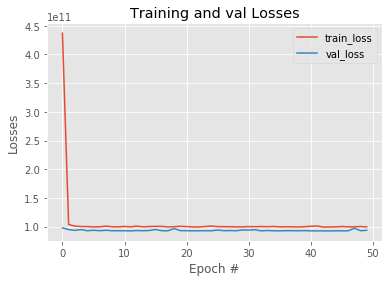

In [40]:
import matplotlib.pyplot as plt

plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0,len(train_losses)), train_losses, label="train_loss")
plt.plot(np.arange(0, len(test_losses)), test_losses, label="val_loss")
plt.title("Training and val Losses")
plt.xlabel("Epoch #")
plt.ylabel("Losses")
plt.legend()
plt.show()